# **Unsupervised Brain Tumor Segmentation Using K-means Clustering Algorithm**

This notebook focuses on **brain tumor segmentation** by utilizing **K-Means clustering** on MRI scans. The goal is to segment the tumor into its key subregions: **edema**, **enhancing tumor**, and **necrosis**, which are critical for diagnosis, treatment planning, and analysis. Initially, we isolate the tumor region through a thresholding approach, followed by applying K-Means clustering to refine the segmentation.

To assess the performance of the segmentation, we use evaluation metrics such as the **Dice coefficient**, **confusion matrix**, **precision**, and **recall**.

### **Objectives of the Notebook:**
1. **Detecting the tumor region** using a thresholding approch.
2. **Applying K-Means clustering** to segment the tumor into its subregions.
3. **Visualizing the segmentation results** to compare predicted segmentation with the ground truth.
4. **Evaluating segmentation performance** using the Dice coefficient, confusion matrix, precision, and recall.

First, let's import the necessary libraries for this notebook.

In [2]:
import os
from glob import glob
import google.colab.drive as drive

import nibabel as nib
import numpy as np
from ipywidgets import interact,fixed
import matplotlib.pyplot as plt

from skimage import color
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score

from visualize import display_volume_slices, explore_3dimage, explore_4dimage, create_rgb_masks, explore_labeled_image
from detection import detect_tumor_thresholding, postprocess_tumor_mask
from metrics import create_confusion_matrix, dice_coefficient

%matplotlib inline

We mount the drive in Colab

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Next, we extract the contents of the tar file, which contains the dataset. The following command is used to extract the tar file:

In [ ]:
!tar -xvf "/content/drive/MyDrive/Task01_BrainTumour.tar"

## **Data Loading**
Let's load a sample data

In [5]:
subject="BRATS_001"
im = nib.load('/content/Task01_BrainTumour/imagesTr/{}.nii.gz'.format(subject))
mask = nib.load('/content/Task01_BrainTumour/labelsTr/{}.nii.gz'.format(subject))

im_data = im.get_fdata()
tumor_seg_data = mask.get_fdata()

We visualize the loaded MRI scan volume:

In [6]:
interact(explore_4dimage,
         layer=(0,im_data.shape[2]-1),
         MRI_Seq=(0,im_data.shape[3]-1),
         input_data=fixed(im_data),
         plane='axial')

interactive(children=(IntSlider(value=77, description='layer', max=154), IntSlider(value=1, description='MRI_S…

<function visualize.explore_4dimage(layer, MRI_Seq, input_data, plane='axial')>

## **Brain Tumor Detection**
We perform a modality fusion, as explained in the previous notebook.

In [7]:
fused_mod_img = im_data[:, :, :, 0] * (im_data[:, :, :, 2] + 2000) * im_data[:, :, :, 3] * (10**-6)

We apply our detection pipeline, from thresholding to post-processing. The threshold choice is explained in the previous notebook, as we are continuing with the same sample.

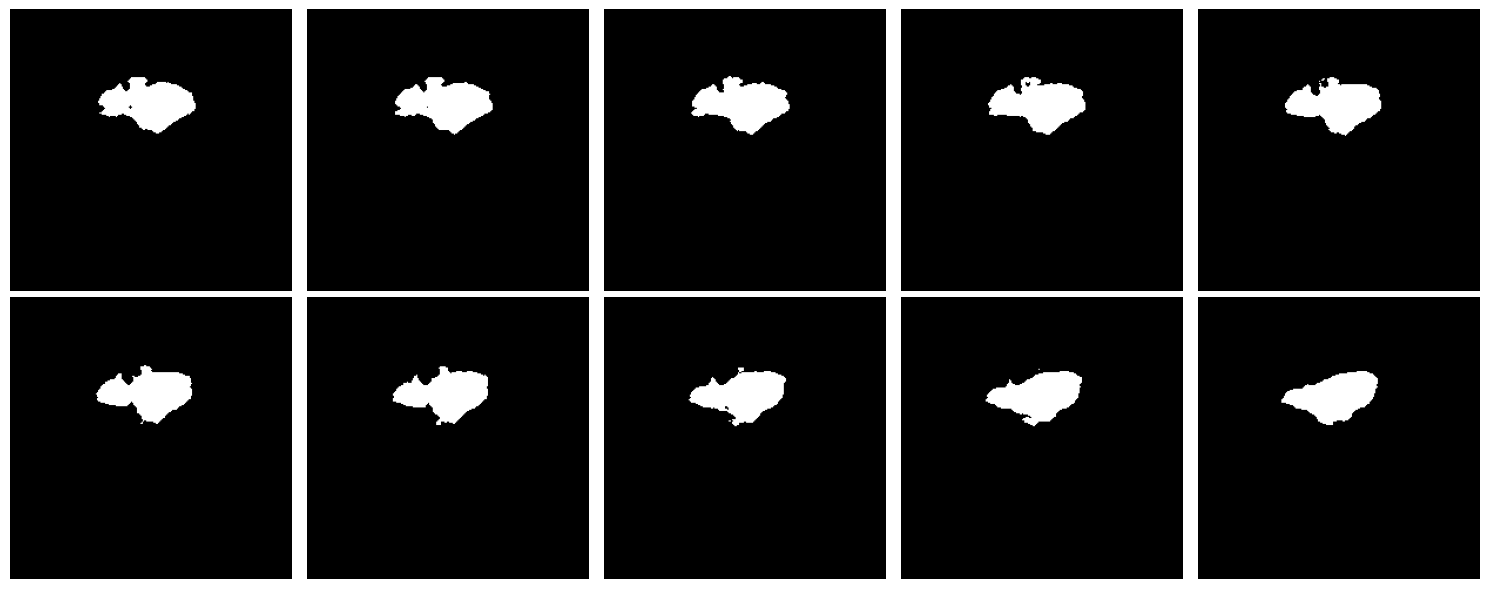

In [8]:
#threshold
t = 1300
# Detect tumor region
tumor_mask = detect_tumor_thresholding(fused_mod_img, t)
# Post-process the resulting mask
processed_tumor_mask = postprocess_tumor_mask(tumor_mask)
# Visulize the processed mask
display_volume_slices(processed_tumor_mask)

## **Brain Tumor Segmentation**

In this section, we will focus on segmenting the detected tumor region into its core components: **edema**, **enhancing tumor**, and **necrosis** using clustering techniques, specifically **K-Means clustering**. We are not targeting the entire brain but rather concentrating on the already identified tumor area.

This localized segmentation approach allows us to finely classify the tumor into its relevant subregions, which is crucial for further analysis and treatment planning.

### **Select the Modalities for K-Means Clustering**

We will select the MRI modalities that provide the most useful information for tumor segmentation. These modalities will be used as input features for training the K-Means clustering model. Each modality contributes distinct tissue contrasts that aid in differentiating tumor subregions.

Let's check the ground truth mask. A detailed interpretation of the ground truth can be found in the first notebook

In [9]:
interact(explore_3dimage,
         layer=(0,tumor_seg_data.shape[2]-1),
         input_data=fixed(tumor_seg_data),
         plane='axial')

interactive(children=(IntSlider(value=77, description='layer', max=154), Text(value='axial', description='plan…

<function visualize.explore_3dimage(layer, input_data, plane='axial')>

Let’s examine the different MRI modalities and how the various tumor subregions are represented:

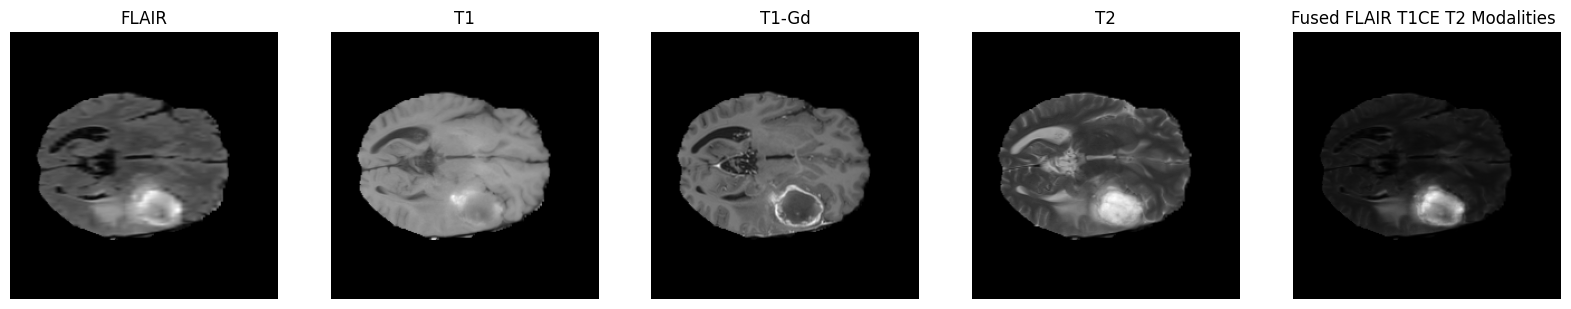

In [10]:
# Plot the 70th slice of the 4 RMI modalities and the segmentation mask
slice_nb = 70

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(im_data[:,:,slice_nb,0], cmap="gray")
axs[0].set_title('FLAIR')
axs[0].axis('off')

axs[1].imshow(im_data[:,:,slice_nb,1], cmap="gray")
axs[1].set_title('T1')
axs[1].axis('off')

axs[2].imshow(im_data[:,:,slice_nb,2], cmap="gray")
axs[2].set_title('T1-Gd')
axs[2].axis('off')

axs[3].imshow(im_data[:,:,slice_nb,3], cmap="gray")
axs[3].set_title('T2')
axs[3].axis('off')

axs[4].imshow(fused_mod_img[:,:,slice_nb], cmap="gray")
axs[4].set_title('Fused FLAIR T1CE T2 Modalities ')
axs[4].axis('off')
plt.show()

We apply the generated mask to the T1ce and T2-weighted images because these modalities offer complementary information for tumor segmentation:

- **T1ce**: Clearly highlights the **enhancing tumor** region.
- **T2**: Accurately depicts the **necrosis** within the tumor.

The **edema** region is captured from the processed tumor mask, as it is not well represented in these modalities. Although the **FLAIR** modality is effective in showing edema, including FLAIR in K-Means clustering with T1ce and T2 resulted in less accurate segmentation. This is due to the FLAIR's inability to clearly distinguish between **enhancing tumor** and **necrosis**, as these regions appear interconnected in FLAIR, leading to confusion in the clustering process. Therefore, we exclude FLAIR for more precise segmentation of tumor subregions.

In [11]:
# Extract tumor data and apply the mask
tumor_data = im_data[:, :, :, 2:4] * processed_tumor_mask[..., np.newaxis]

### **Train the K-Means Model**

Using the selected modalities, we will train a K-Means model to cluster the tumor region into three main classes corresponding to the edema, enhancing tumor, and necrosis.

K-Means is an unsupervised learning method commonly used for segmentation tasks in medical imaging, as it groups pixels based on their intensity similarities.



In [12]:
# Flatten the tumor data for clustering
X = tumor_data.reshape(-1, tumor_data.shape[-1])

# Define initial centroids for KMeans
initial_centroids = np.array([[0, 0], [500, 500], [1000, 1000], [1750, 1750]])

# Fit KMeans and predict labels
kmeans = KMeans(n_clusters=4, init=initial_centroids, n_init=1, random_state=0)
labels = kmeans.fit_predict(X)

# Reshape the predicted labels back to the original tumor data shape
tumor_seg_predict = labels.reshape(tumor_data.shape[:-1])

# Display the predicted tumor mask
interact(explore_3dimage,
         layer=(0,tumor_seg_predict.shape[2]-1),
         input_data=fixed(tumor_seg_predict),
         plane='axial')

interactive(children=(IntSlider(value=77, description='layer', max=154), Text(value='axial', description='plan…

<function visualize.explore_3dimage(layer, input_data, plane='axial')>

**Note**: By applying K-Means clustering to this smaller region, we aim to segment the tumor into its main components with greater accuracy and computational efficiency.

In [ ]:
#save the tumor segmentation prediction
tumor_segmentation_prediction = nib.Nifti1Image(tumor_seg_predict, im.affine, im.header)
nib.save(tumor_segmentation_prediction,'/content/Tumor_Segmentation_Prediction_{}.nii.gz'.format(subject))

### **Visualize the Segmentation Results**

We will implement a function to interactively visualize the predicted segmentation overlaid on the brain MRI scan for qualitative evaluation. This function will blend the ground truth segmentation and the predicted segmentation on top of the MRI slices to provide an intuitive way of assessing how well the model has segmented the tumor components.

In [13]:
# Define colors for different tumor regions
colors = {
    "red": [1, 0, 0],    # Edema/Invation (red)
    "blue": [0, 0, 1],   # Necrosis (blue)
    "green": [0, 1, 0]   # Enhancing Tumor (green)
}

predict_mask_edema = create_rgb_masks(tumor_seg_predict, 1)
predict_mask_necrosis = create_rgb_masks(tumor_seg_predict, 2)
predict_mask_enhancing_tumor = create_rgb_masks(tumor_seg_predict, 3)

gt_mask_edema = create_rgb_masks(tumor_seg_data, 1)
gt_mask_necrosis = create_rgb_masks(tumor_seg_data, 2)
gt_mask_enhancing_tumor = create_rgb_masks(tumor_seg_data, 3)

# Create combined RGB masks for predicted and ground truth tumor regions
tumor_mask_predict_rgb = (colors['red'] * predict_mask_edema +
                          colors['blue'] * predict_mask_necrosis +
                          colors['green'] * predict_mask_enhancing_tumor)

tumor_mask_data_rgb = (colors['red'] * gt_mask_edema +
                       colors['blue'] * gt_mask_necrosis +
                       colors['green'] * gt_mask_enhancing_tumor)

interact(explore_labeled_image,
         layer=(0,im_data.shape[2]-1),
         MRI_Seq=(0,im_data.shape[3]-1),
         input_data=fixed(im_data),
         predict_seg=fixed(tumor_mask_data_rgb),
         gt_seg=fixed(tumor_mask_predict_rgb))

interactive(children=(IntSlider(value=77, description='layer', max=154), IntSlider(value=1, description='MRI_S…

<function visualize.explore_labeled_image(layer, MRI_Seq, input_data, predict_seg, gt_seg)>

### **Quantitative Evaluation**

#### **Dice Similarity Coefficient**

We will compute the Dice coefficient for each segmented class to quantify the overlap between the predicted and ground truth segmentations.

The **Dice Coefficient** (also called **Dice Similarity Index** and **Dice Similarity Coefficient**) is a statistical measure used to gauge the similarity between two sets, particularly in the context of image segmentation. It compares the overlap between a predicted segmentation and the ground truth.

The Dice coefficient is defined as:

$$
\text{DSC} = \frac{2 \times |A \cap B|}{|A| + |B|} = \frac{2 \times |\text{Intersection}|}{|\text{Predicted mask}| + |\text{True mask}|}
$$

Where:
- $A$ is the set of predicted pixels (or voxels in 3D).
- $B$ is the set of ground truth pixels (or voxels).
- $|A \cap B|$ represents the number of overlapping pixels between the predicted and ground truth segmentations.

The Dice score ranges from **0** (no overlap) to **1** (perfect overlap). It is particularly useful in medical imaging for comparing the predicted and actual regions of interest, such as tumor segmentation.

##### **Dice Similarity Coefficient Measure for The Background Region**

In [14]:
# Generate binary masks for the background (where the tumor mask is 0)
background_true = (tumor_seg_data == 0).astype(int)
background_pred = (tumor_seg_predict == 0).astype(int)

# Calculate the Dice coefficient for the background
bg_dice = dice_coefficient(background_pred, background_true)

# Print the result
print(f"DSC for the Background Region: {bg_dice:.4f}")

DSC for the Background Region: 0.9989


##### **Dice Similarity Coefficient Measure for The Edema Region**

In [15]:
# Generate binary masks for the edema region (where the tumor mask is 1)
edema_true = (tumor_seg_data == 1).astype(int)
edema_pred = (tumor_seg_predict == 1).astype(int)

# Calculate the Dice coefficient for the edema region
edema_dice = dice_coefficient(edema_pred, edema_true)

# Print the result
print(f"DSC for the Edema Region: {edema_dice:.4f}")

DSC for the Edema Region: 0.7898


##### **Dice Similarity Coefficient Measure for The Necrosis Region**

In [16]:
# Generate binary masks for the necrosis region (where the tumor mask is 2)
necrosis_true = (tumor_seg_data == 2).astype(int)
necrosis_pred = (tumor_seg_predict == 2).astype(int)

# Calculate the Dice coefficient for the necrosis region
necrosis_dice = dice_coefficient(necrosis_pred, necrosis_true)

# Print the result
print(f"DSC for the Necrosis Region: {necrosis_dice:.4f}")

DSC for the Necrosis Region: 0.8601


##### **Dice Similarity Coefficient Measure for Enhancing Tumor Region**

In [17]:
# Generate binary masks for the enhancing tumor region (where the tumor mask is 3)
enhancing_tumor_true = (tumor_seg_data == 3).astype(int)
enhancing_tumor_pred = (tumor_seg_predict == 3).astype(int)

# Calculate the Dice coefficient for the enhancing tumor region
enhancing_tumor_dice = dice_coefficient(enhancing_tumor_pred, enhancing_tumor_true)

# Print the result
print(f"DSC for the Enhancing Tumor Region: {enhancing_tumor_dice:.4f}")

DSC for the Enhancing Tumor Region: 0.8242


#### **Confusion Matrix**

To further assess the model’s performance, we will compute a confusion matrix that compares the predicted segmentation with the ground truth on a per-class basis. This will provide insight into the number of correctly and incorrectly classified pixels for each class.

The **Confusion Matrix** is a table used to evaluate the performance of a classification algorithm by comparing the predicted and actual class labels. In the context of segmentation, each element of the matrix counts the number of pixels (or voxels) classified into different categories.

A confusion matrix for binary classification looks like this:

|                  | **Predicted Positive** | **Predicted Negative** |
|------------------|------------------------|------------------------|
| **True Positive** | True Positive (TP)     | False Negative (FN)    |
| **True Negative** | False Positive (FP)    | True Negative (TN)     |

Where:
- **True Positive (TP)**: Correctly predicted positive pixels.
- **False Positive (FP)**: Pixels incorrectly predicted as positive.
- **True Negative (TN)**: Correctly predicted negative pixels.
- **False Negative (FN)**: Pixels incorrectly predicted as negative.

The confusion matrix helps compute important metrics such as **precision** and **recall**, which provide insight into the segmentation model's performance.

In multiclass segmentation, the confusion matrix becomes more complex, containing rows and columns for each class (background, edema, enhancing tumor, necrosis).

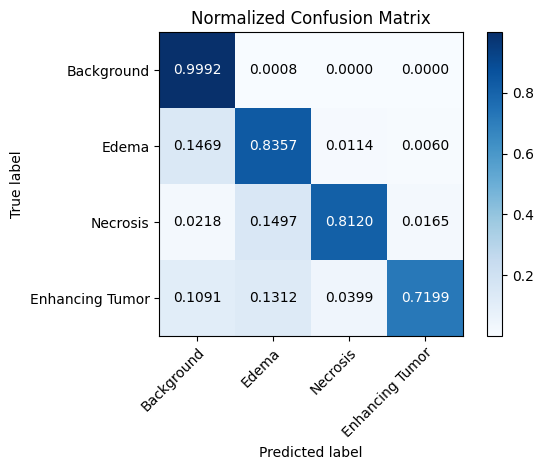

In [18]:
class_names = ['Background', 'Edema', 'Necrosis', 'Enhancing Tumor'] # Names of your classes

# Flatten the arrays to ensure they are 1D
y_true = tumor_seg_data.flatten()
y_pred = tumor_seg_predict.flatten()

# Create and display the confusion matrix
_, cm= create_confusion_matrix(y_true , y_pred ,
                               classes=class_names, normalize=True,
                               title='Normalized Confusion Matrix')

#### **Precision & Recall**

**Precision** and **recall** are key metrics for evaluating the accuracy of the segmentation for each tumor subregion.

##### **Precision:**
Precision measures the proportion of true positive (correctly identified) pixels for a particular class relative to all pixels that were predicted to belong to that class (both true positives and false positives). In other words, it tells us how many of the pixels that were predicted to belong to a specific class were actually correct.

For a specific class $c$ :
$$
\text{Precision}_c = \frac{\text{True Positives}_c}{\text{True Positives}_c + \text{False Positives}_c}
$$


- **High precision** means that most of the pixels predicted to be from class $c$ are indeed from class $c$ (few false positives).
- **Low precision** indicates that many of the pixels predicted as class $c$ were actually misclassified.

##### **Recall:**
Recall (or sensitivity) measures the proportion of true positive pixels for a class relative to all actual pixels belonging to that class (both true positives and false negatives). It reflects how well the model is able to identify all the pixels of a given tumor subregion.

For a specific class $c$ :
$$
\text{Recall}_c = \frac{\text{True Positives}_c}{\text{True Positives}_c + \text{False Negatives}_c}
$$

- **High recall** means that the model successfully identifies most of the class $c$ pixels in the ground truth (few false negatives).
- **Low recall** indicates that the model misses many pixels that should have been classified as class $c$.

Since brain tumor segmentation involves multiple classes, precision and recall need to be computed for each class. we can calculate the precision and recall for each class individually and either report them separately or compute overall metrics using methods like:
- **Macro-averaging**: Compute precision and recall for each class independently and then take their unweighted mean.
- **Micro-averaging**: Aggregate the true positives, false positives, and false negatives across all classes, then compute precision and recall from these aggregated values.

##### **Precision & Recall for The Background Region**

In [19]:
# Calculate precision and recall for the bg class
bg_precision = precision_score(y_true, y_pred, labels=[0], average='macro')
bg_recall = recall_score(y_true, y_pred, labels=[0], average='macro')

print(f"Precision for the Background Region (Macro-averaging): {bg_precision:.4f}")
print(f"Recall for the Background Region (Macro-averaging): {bg_recall:.4f}")

Precision for the Background Region (Macro-averaging): 0.9987
Recall for the Background Region (Macro-averaging): 0.9992


##### **Precision & Recall for The Edema Region**

In [20]:
# Calculate precision and recall for the edema class
edema_precision = precision_score(y_true, y_pred, labels=[1], average='macro')
edema_recall = recall_score(y_true, y_pred, labels=[1], average='macro')

print(f"Precision for the Edema Region (Macro-averaging): {edema_precision:.4f}")
print(f"Recall for the Edema Region (Macro-averaging): {edema_recall:.4f}")

Precision for the Edema Region (Macro-averaging): 0.7487
Recall for the Edema Region (Macro-averaging): 0.8357


##### **Precision & Recall for The Necrosis Region**

In [21]:
# Calculate precision and recall for the necrosis class
necrosis_precision = precision_score(y_true, y_pred, labels=[2], average='macro')
necrosis_recall = recall_score(y_true, y_pred, labels=[2], average='macro')

print(f"Precision for the Necrosis Region (Macro-averaging): {necrosis_precision:.4f}")
print(f"Recall for the Necrosis Region (Macro-averaging): {necrosis_recall:.4f}")

Precision for the Necrosis Region (Macro-averaging): 0.9144
Recall for the Necrosis Region (Macro-averaging): 0.8120


##### **Precision & Recall for Enhancing Tumor Region**

In [22]:
# Calculate precision and recall for the enhancing tumor class
enhancing_tumor_precision = precision_score(y_true, y_pred, labels=[3], average='macro')
enhancing_tumor_recall = recall_score(y_true, y_pred, labels=[3], average='macro')

print(f"Precision for the Enhancing Tumor Region (Macro-averaging): {enhancing_tumor_precision:.4f}")
print(f"Recall for the Enhancing Tumor Region (Macro-averaging): {enhancing_tumor_recall:.4f}")

Precision for the Enhancing Tumor Region (Macro-averaging): 0.9639
Recall for the Enhancing Tumor Region (Macro-averaging): 0.7199


## **Conclusion**

In this notebook, we implemented brain tumor segmentation using K-Means clustering on MRI scans, focusing on segmenting the tumor into its subregions: **edema**, **enhancing tumor**, and **necrosis**.

The segmentation results were evaluated using key metrics such as the **Dice coefficient**, **confusion matrix**, **precision**, and **recall**, providing both qualitative and quantitative insights into the effectiveness of our approach. We found that the model achieved good results, as evident in the high Dice coefficient, precision and recall, and confusion matrix analysis.

Our workflow establishes a robust pipeline for brain tumor segmentation, forming a foundation for further refinement and clinical applications.

The next logical step after segmenting the tumor into its subregions is to perform **quantitative analysis** of these regions. This could involve:
1. **Volume estimation** of each tumor subregion to monitor progression or treatment response.
2. **Feature extraction** for radiomics, aiming to classify different tumor types or predict patient outcomes.
3. **Integration of advanced machine learning techniques**, such as deep learning, for automated and more precise segmentation.

Expanding this approach with more sophisticated models could further enhance the segmentation accuracy and its utility in clinical applications.